# Benchmarking the Torontonian
This tutorial shows how to use the implementation of the Torontonian implemented in The Walrus

### The Torontonian
The Torontonian of a $2l$-by-$2l$ Hermitian matrix $A = A^\dagger$ is defined as

$\text{tor}(O) = \sum\limits_{S \in \text{P}(|l|)} (-1)^{|S|}\frac{1}{\sqrt{\text{det}(\mathbb{I}-O_{(S)})}}$
where $\text{P}(|l|)$ stands for the power set of $\{0,...,l-1\}$.



We can write a pure Python implementation of the formula above as follows:

In [1]:
import itertools
import numpy as np


def powerset(s):  # empty set handled as special case
  for i in range(1, len(s)+1):
    yield from itertools.combinations(s, i)


def matix(mat, idx):
    return mat[idx][:,idx]


def torontonian(mat):
    N = len(mat)
    assert((N & 1) == 0)  # N = 2 * d

    N >>= 1  # determinant of empty matrix is 1

    res = []
    for Z in powerset(list(range(N))):
        idx = [*Z, *(x + N for x in Z)]
        step = np.eye(len(Z) << 1) - matix(mat, idx)

        nom = 2 * ((N - len(Z)) & 1 == 0) - 1
        denom = np.sqrt(np.linalg.det(step))
        res.append(nom / denom)

    term = 2 * ((N & 1) == 0) - 1
    return sum(res) + term

### Using the library

Import the library in the usual way:

In [2]:
from thewalrus import tor

To use it  we need to pass square NumPy arrays as arguments:

In [3]:
import numpy as np

The library provides functions to compute Torontonians of real and complex matrices. The function's arguments must be passed as NumPy arrays.

In [4]:
size = 10
matrix = 1j * np.ones([size, size])
matrix = np.tril(matrix.conjugate(), -1) + np.triu(matrix, 1) + np.eye(size)
torontonian(matrix), tor(matrix)

((-16-16j), (-16-16j))

As a simple example, the Torontonian of a matrix containing ones on the main diagonal, with its upper triangular containing all values of $1i$ (and thus its lower triangular containing all values of $-1i$) is given by $-1^l(2^{l-1}+2^{l-1}i)$

Note that when doing floating point computations with large numbers, precision can be lost.

### Benchmarking the performance of the code

For sizes $n=2,\ldots,14$ we will generate random matrices and measure the (average) amount of time it takes to calculate their Torontonian. The number of samples for each will be geometrically distributed, with 1000 samples for size $n=2$ and 2 samples for $n=14$. The matrices that are input are obtained by generating random covariance matrices of Gaussian states that are then transformed as shown in the function `random_gaussian` below.

In [5]:
a0 = 1000.
anm1 = 2.
n = 7
r = (anm1 / a0) ** (1. / (n - 1))
nreps = [int(a0 * (r ** i)) for i in range(n)]

In [6]:
nreps

[1000, 354, 125, 44, 15, 5, 2]

The following function generates random matrices of dimensions $n$

In [7]:
from thewalrus.random import random_covariance
from thewalrus.quantum.conversions import Amat, Xmat
def random_gaussian(N):
    cov = random_covariance(N)
    O = Xmat(N) @ Amat(cov)
    return O

Now let's benchmark the scaling of the calculation with the matrix size testing both the recursive and non-recursive Torontonian implementations

In [8]:
import time
times, timesrec = np.empty(n), np.empty(n)
for ind, reps in enumerate(nreps):
    size = 2 * (ind + 1)
    A = random_gaussian(size)
    start = time.time()
    for i in range(reps):
        res = tor(A)
    end = time.time()
    timesrec[ind] = (end - start) / reps
    start = time.time()
    for i in range(reps):
        res = tor(A, recursive=False)
    end = time.time()
    times[ind] = (end - start) / reps
    print(2 * (ind + 1), timesrec[ind], times[ind])

2 7.999897003173829e-06 8.999109268188476e-06
4 3.6691541725632836e-05 0.00030167493443031095
6 0.00022416305541992187 0.0033198432922363283
8 0.0010681965134360573 0.023386359214782715
10 0.0036668300628662108 0.14973317782084147
12 0.014800071716308594 0.8551995754241943
14 0.057501792907714844 4.552998304367065


We can now plot the (average) time it takes to calculate the Torontonian vs. the size of the matrix:

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

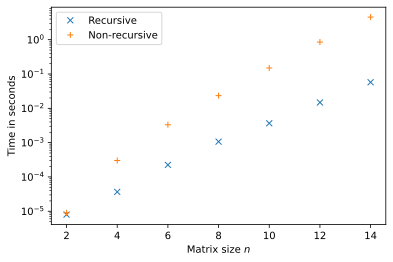

In [10]:
plt.semilogy(2 * np.arange(1, n + 1),timesrec,"x",label="Recursive")
plt.semilogy(2 * np.arange(1, n + 1),times,"+", label="Non-recursive")
plt.xlabel(r"Matrix size $n$")
plt.ylabel(r"Time in seconds")
ax = plt.subplot(111)
ax.legend()
plt.savefig("tor_benchmark.png", format="png")
plt.savefig("tor_benchmark.svg", format="svg")

The specs of the computer on which this benchmark was performed are:

In [11]:
import os
if os.name == "nt":
    !wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status
else:
    !cat /proc/cpuinfo|head -19 

Caption                                 DeviceID  MaxClockSpeed  Name                                      NumberOfCores  Status  

Intel64 Family 6 Model 158 Stepping 13  CPU0      2592           Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz  6              OK      



